In [1]:
# pip install numpy xarray netCDF4 matplotlib plotly

In [2]:
# pip install "dask[complete]" -q

In [3]:
# pip install geopy ipywidgets folium -q

In [4]:
# !jupyter nbextension enable --py widgetsnbextension

In [5]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [6]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import glob
import os
import cftime
import folium
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [17]:
# Data structure for country to subareas mapping
# https://en.wikipedia.org/wiki/List_of_administrative_divisions_by_country
country_to_subareas = {
    "Madagascar": [
                    'Alaotra-Mangoro',
                     "Amoron'i Mania",
                     'Analamanga',
                     'Analanjirofo',
                     'Androy',
                     'Anosy',
                     'Atsimo-Andrefana',
                     'Atsimo-Atsinanana',
                     'Atsinanana',
                     'Betsiboka',
                     'Boeny',
                     'Bongolava',
                     'Diana',
                     'Fitovinany',
                     'Ihorombe',
                     'Itasy',
                     'Matsiatra Ambony',
                     'Melaky',
                     'Menabe',
                     'Sava',
                     'Sofia',
                     'Vakinankaratra',
                     'Vatovavy'
                  ],
    "Italy": [
        "Apulia",
        "Abruzzo",
        "Basilicata",
        "Calabria",
        "Campania",
        "Emilia-Romagna",
        "Friuli Venezia Giulia",
        "Latium",
        "Liguria",
        "Lombardia",
        "Marche",
        "Molise",
        "Piedmont",
        "Sardinia",
        "Sicily",
        "Trentino-Alto Adige",
        "Tuscany",
        "Umbria",
        "Valle d'Aosta",
        "Veneto" 
    ],
    "Brazil": ["São Paulo", "Rio de Janeiro", "Bahia", "Minas Gerais"],
    "India": ["Maharashtra", "Tamil Nadu", "Delhi", "Karnataka"],
}

area_subset_data = None

Exception ignored in: <bound method CachingFileManager.__del__ of CachingFileManager(<class 'netCDF4._netCDF4.Dataset'>, '/data1/drought_dataset/spei/spei12/SPEI12_genlogistic_global_era5_moda_ref1991to2020_198301.nc', mode='r', kwargs={'clobber': True, 'diskless': False, 'persist': False, 'format': 'NETCDF4'})>
Traceback (most recent call last):
  File "/home/marina/tales-of-drought/lib64/python3.6/site-packages/xarray/backends/file_manager.py", line 244, in __del__
    self.close(needs_lock=False)
  File "/home/marina/tales-of-drought/lib64/python3.6/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2624, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2587, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2028, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not a valid ID
Exception ignored in: <bound method CachingFileManager.__del__ of CachingF

In [8]:
def adjust_to_nearest_025(coord):
    """
    Adjust the given coordinate value to the nearest multiple of 0.25.
    
    Args:
    coord (float): The coordinate value to adjust.
    
    Returns:
    float: Adjusted coordinate value, rounded to the nearest multiple of 0.25.
    """
    return np.round(coord * 4) / 4

In [9]:
# This function is because ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon)) seems not working
def generate_coordinate_values(start_coord, end_coord):
    """
    Generate a list of coordinate values from start to end, adjusted to the nearest 0.25 increment.
    
    Args:
    start_coord (float): The starting coordinate.
    end_coord (float): The ending coordinate.
    
    Returns:
    list: A list of coordinates from start to end, adjusted to 0.25 increments.
    """
    adjusted_start = adjust_to_nearest_025(start_coord)
    adjusted_end = adjust_to_nearest_025(end_coord)
    
    # Ensure start is less than end
    adjusted_start, adjusted_end = min(adjusted_start, adjusted_end), max(adjusted_start, adjusted_end)
    
    # Generate values within the range
    coordinate_values = np.arange(adjusted_start, adjusted_end + 0.25, 0.25)
    return coordinate_values.tolist()

In [10]:
# Map to verify that the selected area is the one of interest
def display_map(bounds):
    # Create a map centered around the middle of the bounds
    center_lat = (bounds[0] + bounds[1]) / 2
    center_lon = (bounds[2] + bounds[3]) / 2
    folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=6)
    
    # Add a rectangle to represent the bounding box
    folium.Rectangle(
        bounds=[(bounds[0], bounds[2]), (bounds[1], bounds[3])],
        color='blue',
        fill=True,
        fill_opacity=0.5
    ).add_to(folium_map)
    
    return folium_map

In [11]:
def preprocess(ds, bounds):
    min_lon, min_lat, max_lon, max_lat = bounds
    latitude_list = generate_coordinate_values(min_lat, max_lat)
    longitude_list = generate_coordinate_values(min_lon, max_lon)
    ds_subset = ds.sel(lat=latitude_list, lon=longitude_list)
    return ds_subset

In [12]:
def handle_area_change(bounds):
    # Function to open and process data files based on selected bounds
    global area_subset_data
    data_path = '/data1/drought_dataset/spei/spei12/'
    file_list = sorted(glob.glob(os.path.join(data_path, 'SPEI12_*01.nc')))
    area_subset_data = xr.open_mfdataset(
        file_list,
        concat_dim='time',
        combine='nested',
        parallel=True,
        preprocess=lambda ds: preprocess(ds, bounds)
    )
    #print("Subsetted latitude values:", subset.lat.values)
    #print("Subsetted longitude values:", subset.lon.values)
    return area_subset_data

In [13]:
# Initialize the Nominatim client
geolocator = Nominatim(user_agent="talesofdrought")

def get_country_bounds(country):
    try:
        # Use geocode to query the country with the parameter for getting bounding box
        location = geolocator.geocode(country, exactly_one=True, timeout=10)
        if location:
            # Extract the bounding box
            bounding_box = location.raw['boundingbox']
            bounds = (float(bounding_box[0]), float(bounding_box[1]),
                      float(bounding_box[2]), float(bounding_box[3]))
            return bounds
        else:
            return "No data found."
    except GeocoderTimedOut:
        print(f"Geocoding timed out for {country}; retrying...")
        time.sleep(1)
        return get_country_bounds(country)  # Retry for this country
    except Exception as e:
        return f"Error retrieving data for {country}: {e}"

In [14]:
# Update the function to handle changes
def update_subarea_selector(*args):
    country = country_selector.value
    bounds = get_country_bounds(country)  # Fetch bounds when a country is selected
    subareas = country_to_subareas.get(country, [])
    subarea_selector.options = [placeholder_subarea] + subareas
    with country_output:
        clear_output(wait=True)
        if isinstance(bounds, tuple):
            print(f"Selected Country: {country}")
            print(f"Latitude Range: {bounds[0]} to {bounds[1]}")
            print(f"Longitude Range: {bounds[2]} to {bounds[3]}")
            # display(display_map(bounds))
        else:
            print(bounds)

In [15]:
def on_subarea_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        subarea = change['new']
        bounds = get_country_bounds(subarea)
        with subarea_output:
            clear_output(wait=True)
            if isinstance(bounds, tuple):
                print(f"Selected subarea: {subarea}")
                print(f"Latitude Range: {bounds[0]} to {bounds[1]}")
                print(f"Longitude Range: {bounds[2]} to {bounds[3]}")
                handle_area_change(bounds)
                display(display_map(bounds)) 
            else:
                print(bounds)

In [16]:
placeholder_country = "Select a country..."
placeholder_subarea = "Select a subarea..."


# First dropdown for countries
country_selector = widgets.Dropdown(
    options=[placeholder_country] + list(country_to_subareas.keys()),
    description='Country:',
    style={'description_width': 'initial'}
)

# Second dropdown for subareas, initially empty
subarea_selector = widgets.Dropdown(
    options=[],
    description='Subarea:',
    style={'description_width': 'initial'}
)

# Output widgets to display results
country_output = widgets.Output()
subarea_output = widgets.Output()

# Watch the country/subarea selectors for changes
country_selector.observe(update_subarea_selector, names='value')
subarea_selector.observe(on_subarea_change, names='value')

# Display widgets
display(country_selector, country_output)
display(subarea_selector, subarea_output)

Dropdown(description='Country:', options=('Select a country...', 'Madagascar', 'Italy', 'Brazil', 'India'), st…

Output()

Dropdown(description='Subarea:', options=(), style=DescriptionStyle(description_width='initial'), value=None)

Output()

In [42]:
print(area_subset_data)

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 263, time: 86)
Coordinates:
  * time     (time) object 1940-01-01T06:00:00 ... 2024-01-01 06:00:00
  * lon      (lon) float64 -22.0 -21.75 -21.5 -21.25 ... 42.75 43.0 43.25 43.5
  * lat      (lat) float64 -18.25 -18.0 -17.75 -17.5 ... 45.0 45.25 45.5 45.75
Data variables:
    SPEI12   (time, lat, lon) float64 dask.array<chunksize=(1, 257, 263), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPEI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 15 13:45:57 2024: cdo -selyear,1940 -selmon,1 /scra...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


In [43]:
# print(area_subset_data['SPEI12'].values)

In [44]:
area_subset_data['SPEI12'] = area_subset_data['SPEI12'].where(area_subset_data['SPEI12'] != -9999.0) # Replace -9999.0 with NaN across the dataset

In [45]:
mean_spei = area_subset_data['SPEI12'].mean(dim=['lat', 'lon'])
print(mean_spei)

<xarray.DataArray 'SPEI12' (time: 86)>
dask.array<mean_agg-aggregate, shape=(86,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1940-01-01T06:00:00 ... 2024-01-01 06:00:00


In [46]:
def assign_color(spei_values):
    colors = []
    for spei in spei_values:
        if spei > 2.0:
            colors.append('#064A78')  # extremely wet
        elif 1.5 < spei <= 2.0:
            colors.append('#49AEFF')  # severely wet
        elif 1.0 < spei <= 1.5:
            colors.append('#61A5CE')  # moderately wet
        elif 0 < spei <= 1.0:
            colors.append('#ACD1E5')  # near-normal / mildly wet
        elif -1.0 < spei <= 0:
            colors.append('#F7BB9F')  # near-normal / mildly dry
        elif -1.5 < spei <= -1.0:
            colors.append('#D96C59')  # moderately dry
        elif -2.0 < spei <= -1.5:
            colors.append('#AF2331')  # severely dry
        else:
            colors.append('#681824')  # extremely dry
    return colors

In [47]:
mean_spei_computed = mean_spei.compute()
print(mean_spei_computed)

<xarray.DataArray 'SPEI12' (time: 86)>
array([            nan, -1.88334359e-01, -1.01265885e+00,  1.11587715e-02,
        4.66473307e-02,  3.33240163e-01, -8.94684213e-02, -1.83762389e-01,
        1.02154753e+00,  6.44047712e-01,  1.49892162e-01,  9.22614354e-01,
        1.19461630e+00,  9.99021429e-01,  1.42808166e+00, -1.88334359e-01,
        3.74426124e-01,  8.97591208e-01,  1.32847162e+00,  3.17849894e-01,
        4.00271999e-01,  4.65484944e-01,  5.66015350e-01,  8.74667421e-01,
        1.22584917e+00,  6.11329748e-01,  4.11801900e-01,  4.98747063e-01,
        1.40624281e+00,  1.02398697e+00,  1.20363617e+00,  4.77698326e-01,
        9.45050377e-01,  1.15937825e+00,  3.85222871e-01,  9.28642579e-01,
        9.53758512e-01, -1.88334359e-01,  6.45806224e-01,  1.05727368e+00,
        8.66790049e-01,  7.05783152e-01,  4.33658278e-01,  7.67107453e-01,
       -1.29891874e-01,  2.29036309e-01,  7.59986799e-01,  6.58613113e-01,
        2.65396826e-01,  8.66673603e-01,  4.57488999e-01, -4.

In [48]:
# Extract times and values for plotting
times = mean_spei_computed['time'].values
values = mean_spei_computed.values
colors = assign_color(values)

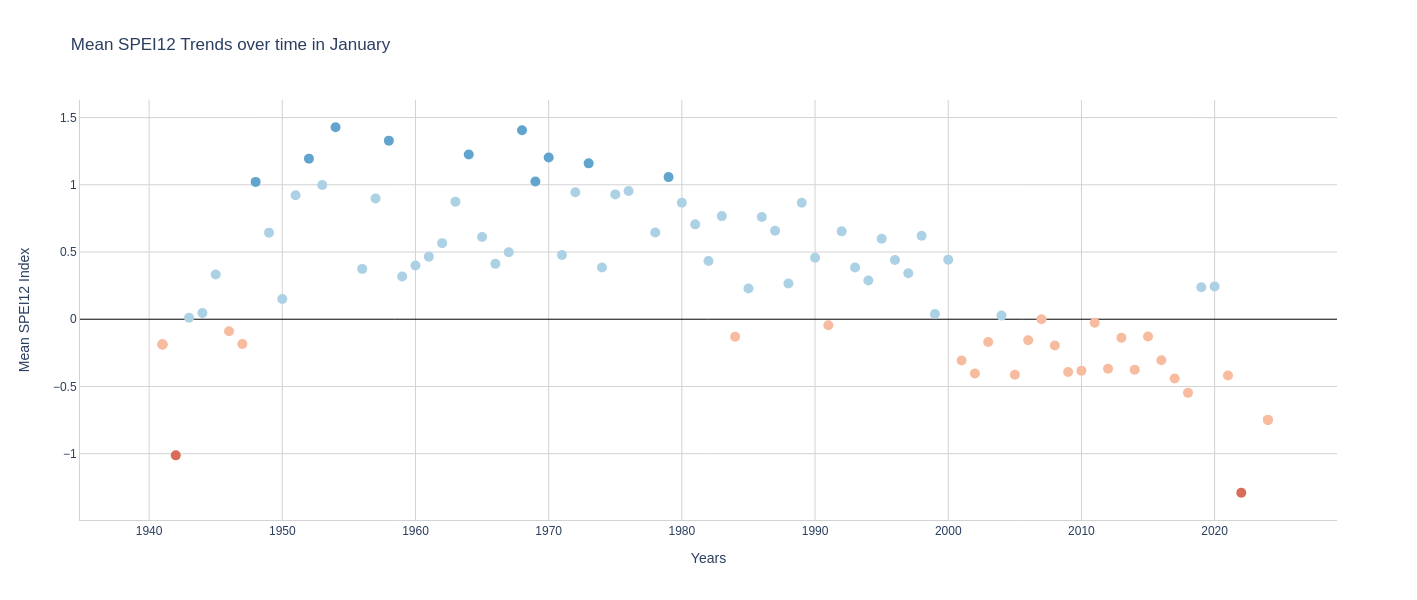

In [49]:
trace = go.Scatter(
    x=times,
    y=values,
    mode='markers',
    name='Mean SPEI12',
    marker=dict(size=10,
                color=colors,
                line=dict(width=0,
                          color='#717BFA')))

# Initialize and update the figure
fig = go.Figure([trace])
fig.update_layout(
    title='Mean SPEI12 Trends over time in January',
    xaxis_title='Years',
    yaxis_title='Mean SPEI12 Index',
    height=600,
    plot_bgcolor='white',         # Sets the plotting area background color
    paper_bgcolor='white',  # Sets the overall background color of the chart
    xaxis=dict(
        showgrid=True,  # Enable grid (default)
        gridcolor='lightgray',  # Set grid color
        linecolor='lightgray',  # Set axis line color
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        linecolor='lightgray',
                zeroline=True,  # Ensure the zero line is visible
        zerolinewidth=1,
        zerolinecolor='black'  # Change zero line color to blue
    )
)

fig.show()